We hereby declare that we have answered these exam questions ourselves without any outside help.

# Intro


## Outline / table of contents

## Imports, functions etc.

In [2]:
# imports
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import xarray as xr
import matplotlib.pyplot as plt

/var/folders/90/hzvrpycd5ds6jx99ygz9bbk00000gn/T/ipykernel_80095/340052179.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
#style
az.style.use("arviz-whitegrid")

In [4]:
#seed
RANDOM_SEED = 8927
RNG = np.random.default_rng(RANDOM_SEED)

## Helper Functions

In [5]:
def standardize_column(column):
    '''
    Transforms column by its z-score.
    '''
    standardized_column = (column - column.mean()) / column.std()
    
    return standardized_column

def transform_exp(x):
    '''
    Transform a value to its exponential value. 
    '''
    return np.exp(x)

## EDA

In [6]:
## load data
df = pd.read_csv('dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1127 entries, 0 to 1126
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   project       1127 non-null   object
 1   language      1127 non-null   object
 2   commits       1127 non-null   int64 
 3   insertions    1127 non-null   int64 
 4   age           1127 non-null   int64 
 5   bugs          1127 non-null   int64 
 6   project_type  1127 non-null   object
 7   devs          1127 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 70.6+ KB


#### Catagorical Feature exploration


In [7]:
df_cat = df.select_dtypes(include = ['O'])
for column in df_cat.columns:
  print('===========================')
  print(f'Column name: {column}')
  print('===========================')
  print(f'# of unique values: {len(df_cat[column].value_counts())}')
  print(f'# of average counts: {df_cat[column].value_counts().mean()}')
  print()

Column name: project
# of unique values: 729
# of average counts: 1.5459533607681757

Column name: language
# of unique values: 17
# of average counts: 66.29411764705883

Column name: project_type
# of unique values: 7
# of average counts: 161.0



In [8]:
# standardize columns
df['age_std'] = standardize_column(df['age'])
df['commits_std'] = standardize_column(df['commits'])
df['bugs_std'] = standardize_column(df['bugs'])

## factorize categorical
df["language"], languages = pd.factorize(df["language"])
df["project_type"], project_types = pd.factorize(df["project_type"])


# Analysis

## H1

### Poisson Regression

 **H1** - Haskell code is less prone to contain bugs (B). In other words, the distribution on the number of bugs (B) for Haskell gives high probability to the lowest number of bugs among all programming languages (L). 

We model the number of bugs with a poisson regression, to get the expected count of bugs for some language with the following model, that includes language as predictors and an intercept:
 $$ B_i \sim Poisson(\lambda_i) \\
log(\lambda_i) = \alpha + \beta_{L} * L_i\\
\alpha = \text{not yet determined} \\ 
\beta_{L} = \text{not yet determined} $$
Where :
$$L \in \mathcal{L}, where \ \mathcal{L} = \{Python,Java..,C \} \\ |\mathcal{L}|=17 $$


### Prior Predictive Checks

Now what is a good choice of priors for alpha?

* One thing we can we say for sure is that the number of counts cannot be negative but the question is how many bugs an average project might have? First of all, there need to be some software pushed to the project, which is denoted by the number of commits **C**. As soon as a project has one commit, there must also be some probability that there is some bug in that pushed code. Based on own work experience, the number commits depending on what type of project, can range from a few commits to a 100. Some projects in the dataset we believe are much bigger meaning they have many more commits. A naive liveable space for the expected number of bugs would be in the interval $\lambda_i \in [0, \infty)$. Given our own experience, say that our project has a 100 commits and we are terrible programmers, this project would have a 100 bugs, so this is still a very large upper bound for the number of bugs. A more reasonable expected number of bugs could be a $1000$. 

* This belief about $\lambda_i$ is aimed to be reflected in the choice of prior for $\alpha$ that is the average number of bugs for a project.
* Since the expected value of $\lambda$ has a logarithmic relationship  to $\alpha$, the choice of priors can lead to exploding number of bugs using a prior with high variance. Another common choice of prior distribution, the standard normal $N(0,1)$, could lead to negative samples, that are mapped to expected value of bugs around 0. This amount of bugs in a project might also seem to good to be true.

* We explore the logarthmic relationship between alpha and the number of bugs with the following candidate prior distributions for alpha:
    * $\alpha \sim Exp(1)$
    * $\alpha \sim N(0,1)$
    * $\alpha \sim log \ N(0,1)$

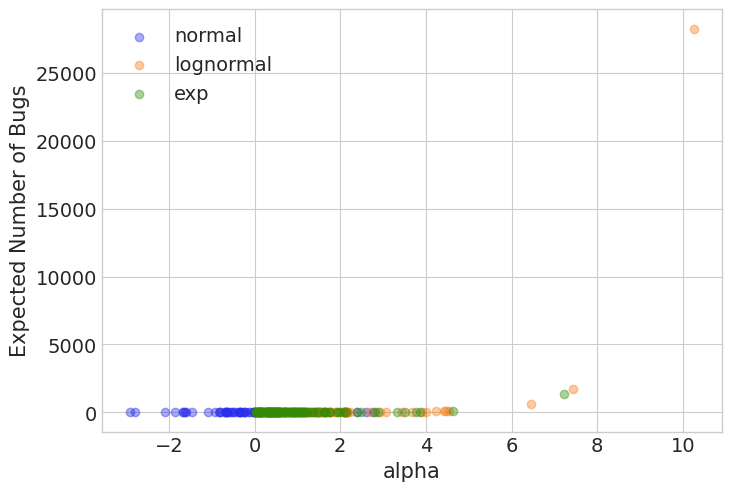

In [149]:
# First Initial Check
n_draws = np.random.normal(0, 1, 100)
ln_draws = np.random.lognormal(0,1,100)
exp_draws = np.random.exponential(1, 100)

plt.scatter(n_draws,np.exp(n_draws),label="normal", alpha=0.4)
plt.scatter(ln_draws,np.exp(ln_draws),label="lognormal", alpha=0.4)
plt.scatter(exp_draws,np.exp(exp_draws), label="exp",alpha=0.4)
plt.xlabel("alpha")
plt.ylabel("Expected Number of Bugs")
plt.legend()
plt.show()

From the plot above, it is already clear that the lognormal distribution yields exploding values for the number of bugs on average.

We can also see, that the normal distribution yields (as expected) a bunch of negative $\alpha$ values, that results in the average number of bugs to be very close to $0$. The exponential distributions heavy tailed characteristic shows from this initialisation a greater tendency than the standard normal $N (0,1)$ to yield exploding values. 

Next we run the prior predictive checks comparing the normal and exponential distribution, to find a good informative prior.

In [150]:
def prior_predictive_check_alpha_normal(alpha_mu_prior, alpha_sigma_prior):
    with pm.Model() as model:
        alpha = pm.Normal("alpha", mu=alpha_mu_prior, sigma=alpha_sigma_prior)
        lam = pm.Deterministic('lambda', pm.math.exp(alpha))
        trace = pm.sample_prior_predictive(samples=100)
        
    return trace, model

def prior_predictive_check_alpha_exp(alpha_lambda_prior):
    with pm.Model() as model:
        alpha = pm.Exponential("alpha", alpha_lambda_prior)
        lam = pm.Deterministic('lambda', pm.math.exp(alpha))
        trace = pm.sample_prior_predictive(samples=100)
        
    return trace, model

Sampling: [alpha]
Sampling: [alpha]
Sampling: [alpha]
Sampling: [alpha]
Sampling: [alpha]
Sampling: [alpha]
Sampling: [alpha]


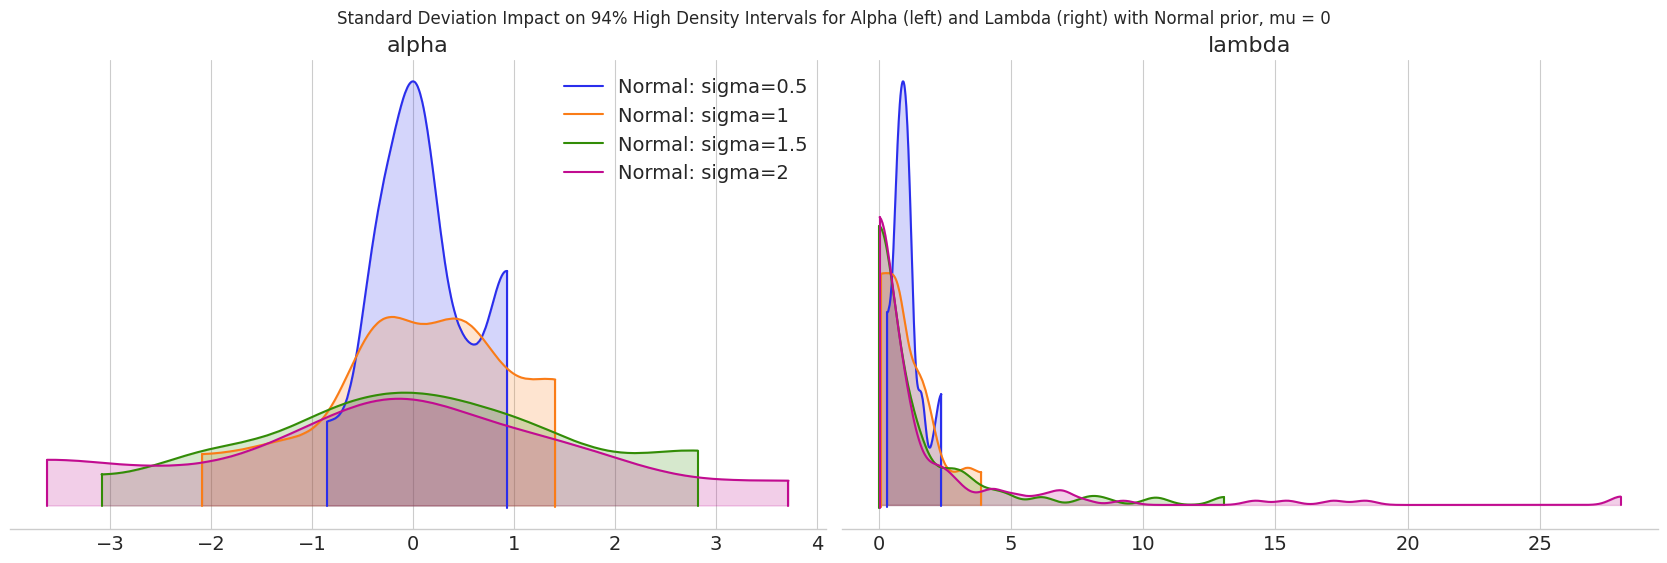

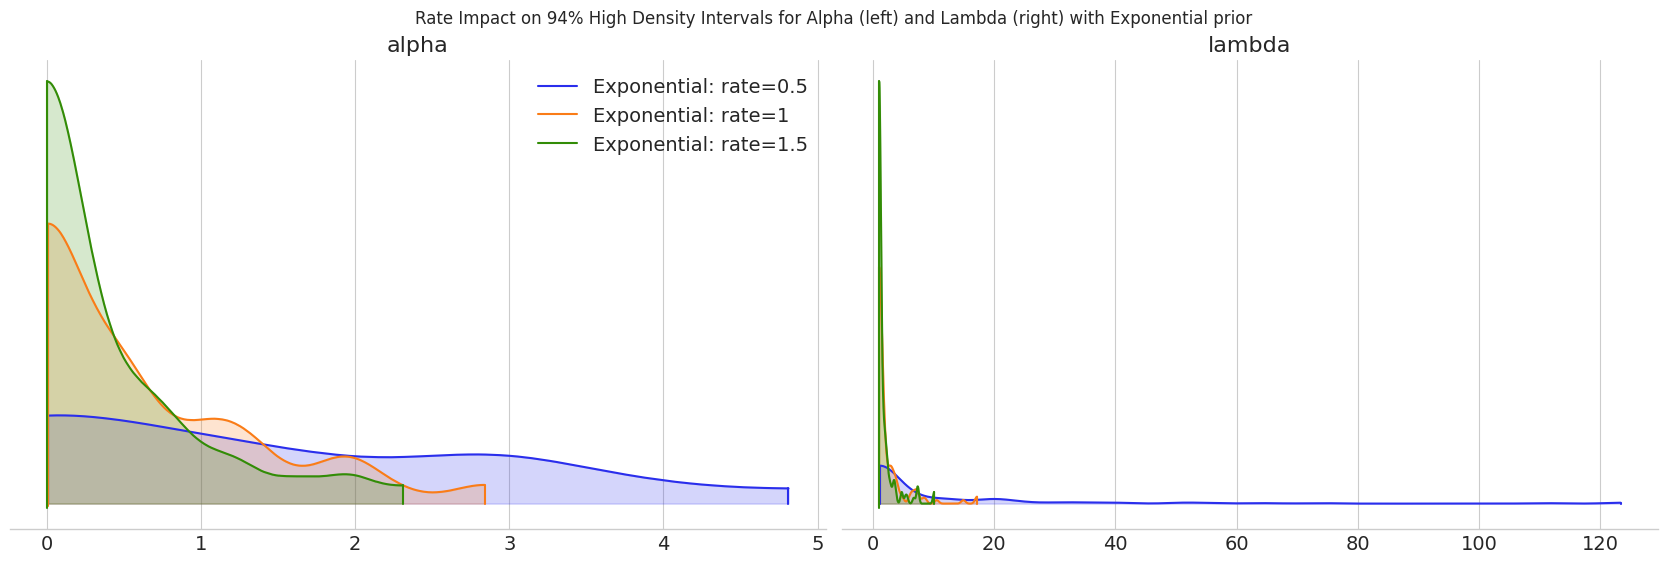

In [151]:
# Fixed Mu, varying sigmas
# Varying rate/lambda parameters
mu = 0
n_sigmas = [0.5, 1, 1.5, 2]
exp_lambdas = [0.5, 1, 1.5]


normal_traces, exponential_traces = [], []
normal_labels, exponential_labels = [], []


for sigma in n_sigmas:
    trace, model = prior_predictive_check_alpha_normal(mu, sigma)
    normal_traces.append(trace.prior)
    normal_labels.append(f"Normal: sigma={sigma}")

for exp in exp_lambdas:
    trace, model = prior_predictive_check_alpha_exp(exp)
    exponential_traces.append(trace.prior)
    exponential_labels.append(f"Exponential: rate={exp}")

axes = az.plot_density(
    normal_traces,
    data_labels=normal_labels,
    var_names=["alpha", "lambda"],
    shade=0.2,
    point_estimate=None,
)

fig = axes.flatten()[0].get_figure()
fig.suptitle("Standard Deviation Impact on 94% High Density Intervals for Alpha (left) and Lambda (right) with Normal prior, mu = 0")

axes = az.plot_density(
    exponential_traces,
    data_labels=exponential_labels,
    var_names=["alpha", "lambda"],
    shade=0.2,
    point_estimate=None,
)

fig = axes.flatten()[0].get_figure()
fig.suptitle("Rate Impact on 94% High Density Intervals for Alpha (left) and Lambda (right) with Exponential prior")

plt.show()


* Based on the above KDE plots and prior predictive checks for Normal distribution with varying $\sigma$ and fixed $\mu=0$ and an exponential distribution with varying rates, it is clear that small changes in the rate (lambda) parameter of an exponential distribution is over sensitive to changes in terms of pushing expected number of bugs too close to $0$ or stretches it too far out, as it is seen with $\lambda = 0.5$. The normal distribution seem to be more a suitable choice of priors for the $\alpha$, although even with a $\sigma=2$ the simulated number of bugs gets a very heavy tail. Now to find the best prior, we fix the standard deviation of 1.5, and try to rid the models from most of the negative values by increasing the $\mu$ parameter.

Sampling: [alpha]
Sampling: [alpha]
Sampling: [alpha]


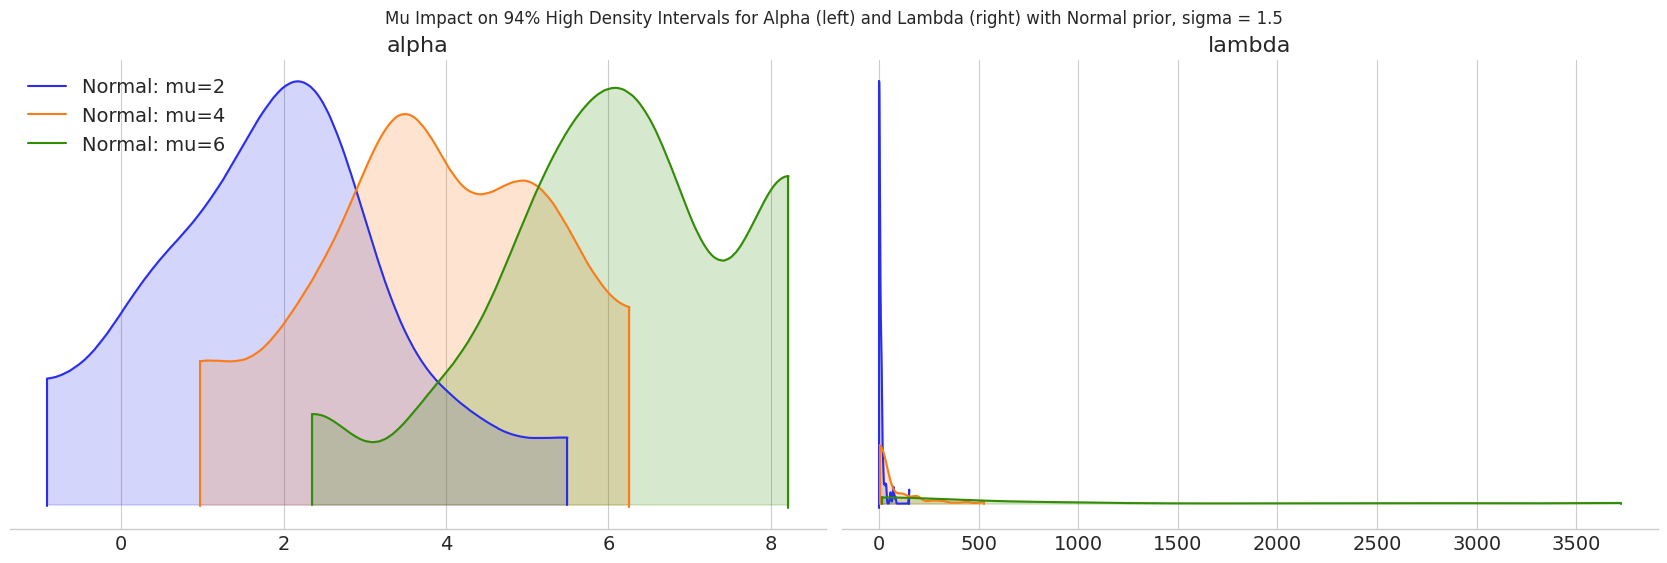

In [152]:
#Fixed Sigma, varying mu
sigma = 1.5
n_mus = [2,4,6]

traces, labels = [], []

for mu in n_mus:
    trace, model = prior_predictive_check_alpha_normal(mu, sigma)
    traces.append(trace.prior)
    labels.append(f"Normal: mu={mu}")

axes = az.plot_density(
    traces,
    data_labels=labels,
    var_names=["alpha", "lambda"],
    shade=0.2,
    point_estimate=None,
)

fig = axes.flatten()[0].get_figure()
fig.suptitle("Mu Impact on 94% High Density Intervals for Alpha (left) and Lambda (right) with Normal prior, sigma = 1.5")
plt.show()

Based on the varying means in the prior predictive sampling for parameters $\alpha$ & $\lambda$ for the poisson distribution, the choice of prior distribution for modeling the average number bugs with $\alpha$ is $N(\mu=6, \sigma=1.5)$ since it shows from the plot above and highlighted below, that the probability mass lies within the range of $[0,\approx 5000)$. This is 10 times more than our own personal projects have had of commits, but these have also been tiny projects, and therefore not representative of what we expect from commercial applications commits and bugs distributions.

$$\alpha \sim N(6,1.5)$$

Sampling: [alpha]


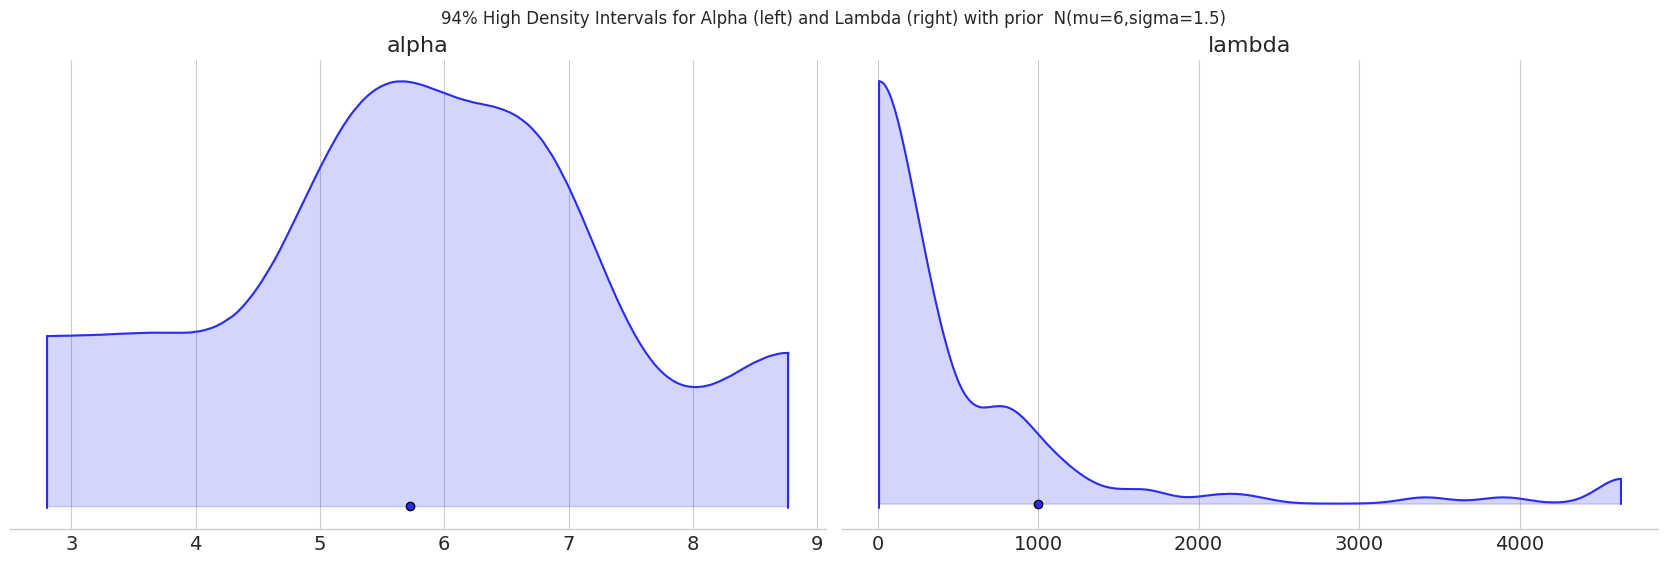

In [153]:
axes = az.plot_density(
    [prior_predictive_check_alpha_normal(6, 1.5)[0].prior],
    data_labels=["Prior Alpha selection = mu=4, sigma=1.5"],
    var_names=["alpha", "lambda"],
    shade=0.2,
    point_estimate="mean",
)

fig = axes.flatten()[0].get_figure()
fig.suptitle("94% High Density Intervals for Alpha (left) and Lambda (right) with prior  N(mu=6,sigma=1.5)")
plt.show()

##### Prior Predictive Check for $\beta_L$


A prior predictive check is again important for having a reasonable estimate for the impact of language. The choice of prior should not explicitly state a positive nor negative relationship between expected number of bugs $\lambda$ and any given language. Ideally, it is a flat prior that can pick up the different effects from a specific language on the number of bugs, from the data. 

This is investigated in the code below. The starting point is an uninformative prior of a standard normal, as we would like coefficients centered around $0$ with both negative and positive samples, to simulate that some languages might have a positive or negative correlation with the number of bugs for a project. 

The $\sigma$ values for the prior distributions below are $\leq 1.5$, to constrain all the languages.


/var/folders/90/hzvrpycd5ds6jx99ygz9bbk00000gn/T/ipykernel_80095/219158400.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


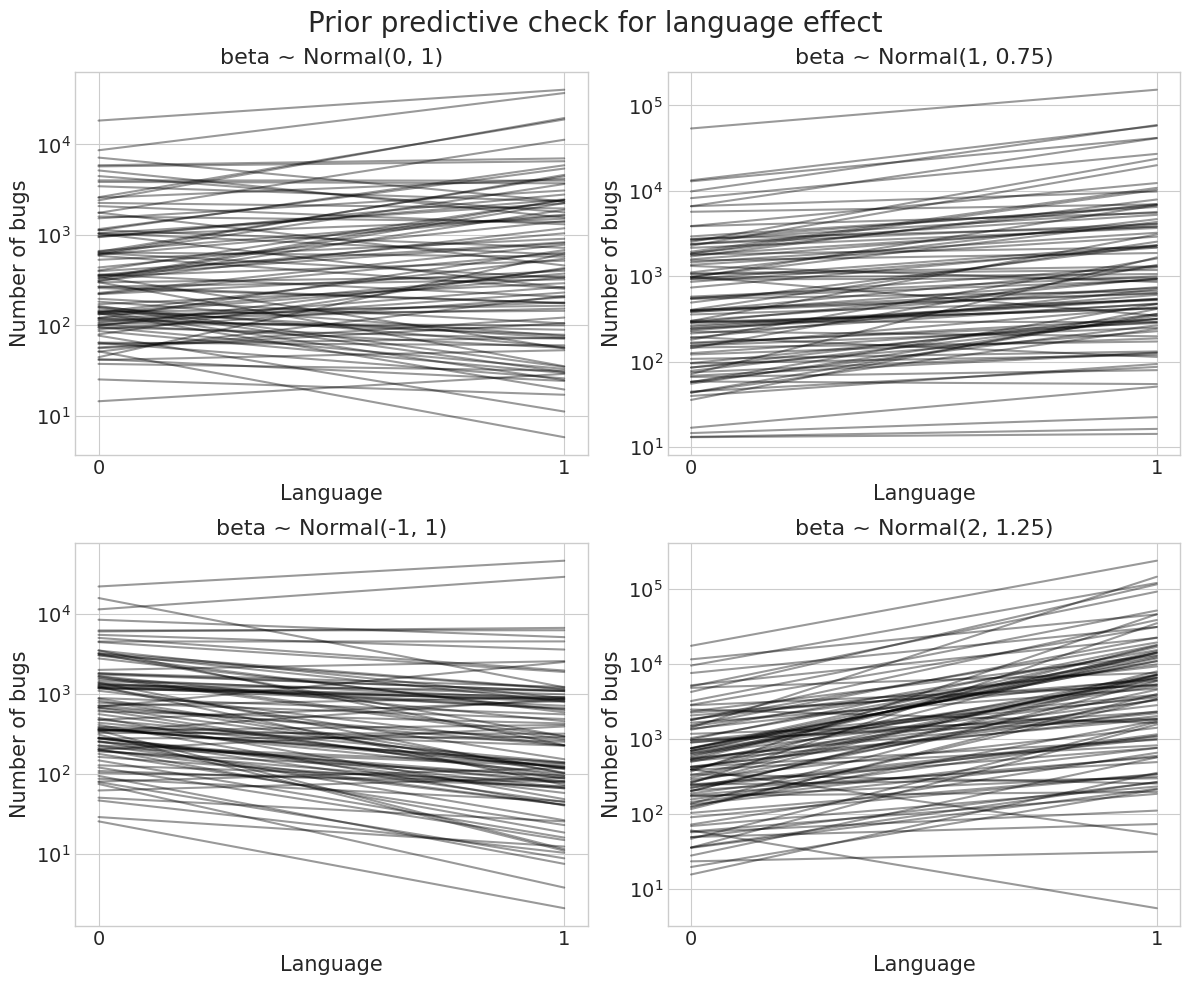

In [154]:
# Adding a language effect
def plot_prior_predictive_check(b_mean,b_std, N: int = 100):
    alphas = np.random.normal(6, 1.5, N)
    betas = np.random.normal(b_mean, b_std, N)
    prior_samples_language_effects = []
    x_axis_data = []
    for a, b in zip(alphas, betas):
        x_seq = np.array([0, 1]) # one hot encoding for language
        # plt.plot(x_seq, np.exp(a + b * x_seq), 'k', alpha=0.4)
        prior_samples_language_effects.append(np.exp(a + b * x_seq))
        x_axis_data.append(x_seq)
    
    return x_axis_data, prior_samples_language_effects

means = [0, 1, -1,2]
stds = [1, 0.75, 1, 1.25, 1.5]

fig, axis = plt.subplots(2,2, figsize=(12, 10))

for mu,std,ax in zip(means, stds, axis.reshape(-1)):
    x_axis_data, prior_samples_language_effects = plot_prior_predictive_check(mu, std)
    for x_seq, y_seq in zip(x_axis_data, prior_samples_language_effects):
        ax.plot(x_seq, y_seq, 'k', alpha=0.4)
    ax.set_title('beta ~ Normal({}, {})'.format(mu, std))
    ax.set_xticks([0, 1])
    ax.set_xlabel("Language")
    ax.set_yscale("log")
    ax.set_ylabel('Number of bugs')

fig.suptitle('Prior predictive check for language effect', fontsize=20)
plt.tight_layout()

The best choice of prior for the beta coefficients is an uninformed standard normal distribution $\beta_L \sim N(0,1)$, this choice does not include any positive or negative trends simply based on the project's programming language, and this is desirable for our poisson regression :
$$ B_i \sim Poisson(\lambda_i) \\
log(\lambda_i) = \alpha + \beta_L * L_i \\
\alpha \sim N(6,1.5) \\ 
\beta_L \sim N(0,1)$$

### Model Fitting

model : <hypothesis_modeltype_model>
trace:  <hypothesis_modeltype_trace>

In [159]:
## Poisson Modeling
with pm.Model() as h1_poisson_model:

      #Data
      language = pm.Data("language", df.language, mutable=True)
      # Priors
      alpha = pm.Normal("alpha", mu=6, sigma=1.5, shape=len(languages))
      # beta_language = pm.Normal("beta_language", mu=0, sigma=1, shape = len(languages))

      #f(theta, x)
      lam= pm.Deterministic('lambda', pm.math.exp(alpha[language]))

      #likelihood
      B = pm.Poisson('B', mu=lam, observed=df.bugs)
      
      h1_poisson_trace = pm.sample(2000, tune=2000,idata_kwargs={'log_likelihood': True}, random_seed=RANDOM_SEED, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2 seconds.


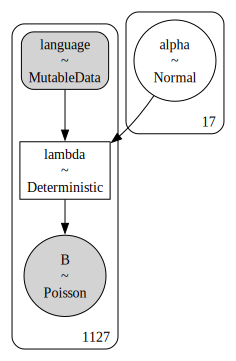

In [160]:
pm.model_to_graphviz(model=h1_poisson_model)

Below is the trace convergence for the parameters $\alpha$ and $\beta_L$.

The number of generated samples is 4 chains * 2000 samples = 8000 samples.

As seen in the table below, the Monte Carlo Standard Error mean `mcse_mean`, is $0$ for all parameters except for `beta_language[0]` of $0.01$. These MSCE's indicate effective sampling of the mode of the distributions in all 4 chains, whilst the equivalent entries in `mcse_sd` show the chains could sample from the mode without high variance. This is also shown by the $>800$ for the `ess_bulk` and `ess_tail`, that shows the number of samples that added new information about the posterior distribution.

In addition, all the `rhat` values are $1.0$ or $1.01$ which means the 4 chains converged. This is also reflected in the trace plot below, which shows good mixing of the chains.

In summary, the convergence of the trace for the poisson regression
 is good and shows no signs of inefficient of inaccuracte sampling. We can therefore use the posterior distributions with high confidence.

In [162]:
az.summary(h1_poisson_trace, var_names=["alpha"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],4.79,0.01,4.77,4.81,0.0,0.0,14934.38,6038.35,1.0
alpha[1],5.26,0.01,5.25,5.27,0.0,0.0,12555.28,4771.13,1.0
alpha[2],4.83,0.01,4.81,4.85,0.0,0.0,16205.90,5125.56,1.0
alpha[3],6.16,0.01,6.15,6.17,0.0,0.0,15529.93,5984.54,1.0
alpha[4],6.72,0.00,6.71,6.73,0.0,0.0,14872.18,6567.39,1.0
alpha[5],6.90,0.00,6.89,6.91,0.0,0.0,14933.95,5775.91,1.0
alpha[6],4.28,0.02,4.24,4.32,0.0,0.0,15678.01,6125.23,1.0
alpha[7],7.71,0.00,7.70,7.71,0.0,0.0,14102.07,5651.11,1.0
alpha[8],6.83,0.00,6.82,6.83,0.0,0.0,14080.57,5671.82,1.0
alpha[9],5.26,0.01,5.24,5.29,0.0,0.0,14516.20,5485.67,1.0


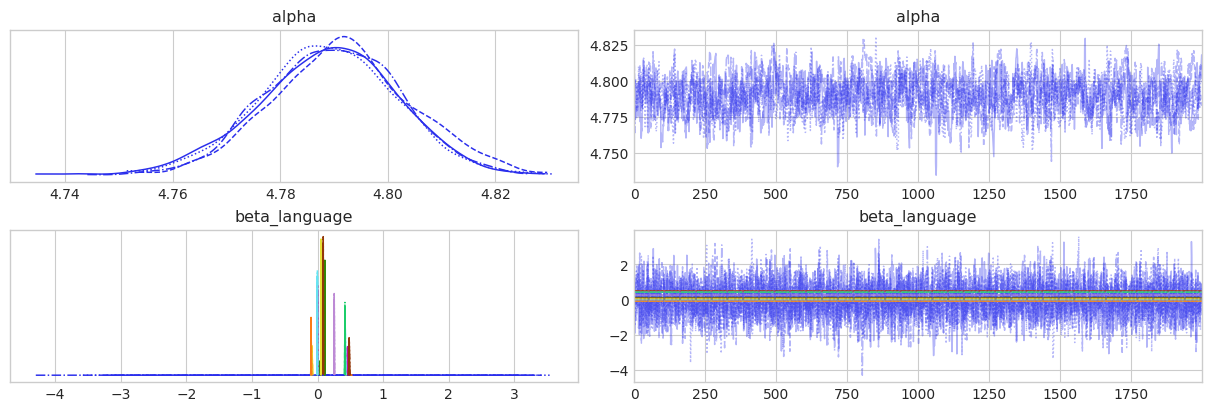

In [21]:
pm.plot_trace(h1_poisson_trace, var_names=['alpha', "beta_language"]);

Below is a forest plot and a numerical representation of the means and standard deviations (sd) from the posterior distributions of the **$\beta_L$** and $\alpha$. The $\alpha$ prior $\mu=6$ is now reduced to $\mu=4.7897$ with a high confidence shown by the $\sigma=0.0127$. This shows that the average number of bugs was overestimated by the prior, but also that the sampling was able to estimate the posterior with high accuracy. Similarly, all the $\beta_L$ except for the `beta_language[0]` has very small standard deviations. This also indicates the confidence of the estimated posterior distributions. The means of the $\beta_L$ distributions show different effects of some languages over the others, but all fall within the small range of $(-0.0982,0.4819)$. Especially the negative effects are notably very close to $0$, whereas the largest mean value for `beta_language[4]`=$0.4819$, which indicates a positive correlation between this particular language and the number of bugs. These differences are also seen below in forest plot.

In [73]:
#summary betas
summary_betas_poisson = pm.summary(h1_poisson_trace, var_names=['beta_language'],round_to=4)[['mean', 'sd']].reset_index(names="parameter")
summary_betas_poisson["language"] = languages.take(summary_betas_poisson.index)
#summary alphas
summary_alpha_poisson = pm.summary(h1_poisson_trace, var_names=['alpha'],round_to=4)[['mean', 'sd']].reset_index(names="parameter")
#combined summary
summary_poisson = pd.concat([summary_alpha_poisson, summary_betas_poisson])
print(summary_poisson)

            parameter    mean      sd      language
0               alpha  4.7897  0.0127           NaN
0    beta_language[0]  0.0014  0.9919       Clojure
1    beta_language[1]  0.4682  0.0138    Javascript
2    beta_language[2]  0.0193  0.0088   Objective-C
3    beta_language[3]  0.4568  0.0046          Java
4    beta_language[4]  0.4819  0.0034           Php
5    beta_language[5]  0.4222  0.0027            C#
6    beta_language[6] -0.0854  0.0044          Perl
7    beta_language[7]  0.4167  0.0019             C
8    beta_language[8]  0.2544  0.0016           C++
9    beta_language[9]  0.0527  0.0019        Erlang
10  beta_language[10]  0.0789  0.0016       Haskell
11  beta_language[11] -0.0982  0.0022    Typescript
12  beta_language[12]  0.1105  0.0012          Ruby
13  beta_language[13] -0.0006  0.0014  Coffeescript
14  beta_language[14]  0.0873  0.0010        Python
15  beta_language[15] -0.0025  0.0013            Go
16  beta_language[16]  0.0531  0.0010         Scala


ValueError: invalid literal for int() with base 10: 'lpha[0'

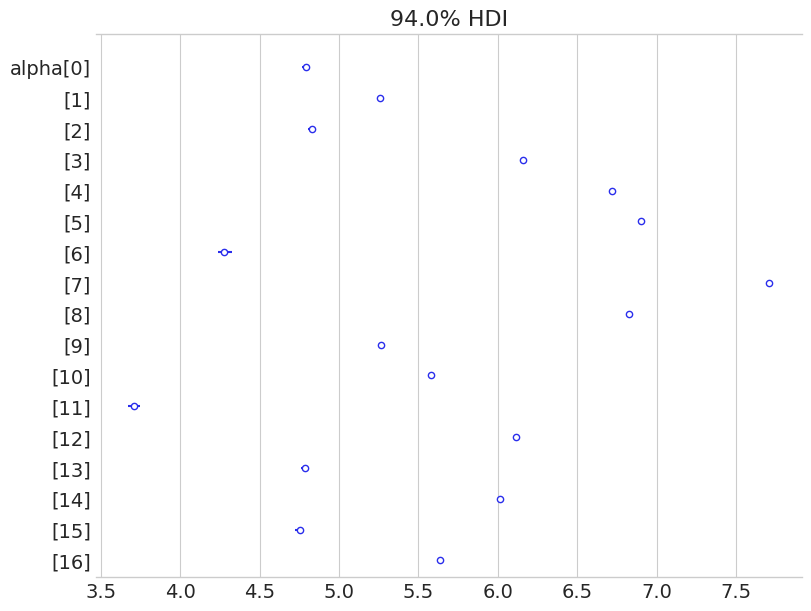

In [163]:
_,ax = plt.subplots(figsize=(8,6))
az.plot_forest(h1_poisson_trace, var_names=["alpha"], combined=True, figsize=(10, 5), ax=ax)
forest_languages = [int(i.get_text()[1:-1]) if len(i.get_text()) < 10 else 0 for i in ax.get_yticklabels()]
ax.set_yticklabels(languages.take(forest_languages)); 

### Posterior Predictive Check

In [78]:
pareto_k_h1 = az.loo(h1_poisson_trace, pointwise=True).pareto_k.values
print("Max PSIS value for beta_language: ", max(pareto_k_h1))

Max PSIS value for beta_language:  83.5427786258926


/Users/AFFO/.pyenv/versions/3.10.4/envs/prob_prog/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


*"Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations"*

This warning indicates that some projects are highly influential on the model, and that taking them at out at random, changes the posterior distribution.

In [105]:
n_points = len(df)
# x_seq = np.random.randint(0, 17,size=n_points)
x_seq = np.array(range(len(languages)))
# print(x_seq)
with h1_poisson_model:
    pm.set_data({"language": x_seq})
    post_pred_h1 = pm.sample_posterior_predictive(h1_poisson_trace, var_names=['lambda'])['posterior_predictive']['lambda']
    
post_pred_h1_mean = post_pred_h1.mean(["chain", "draw"])

Sampling: []


To investigate the highly influential datapoints, below is plotted the Poisson Regression Models 95% HDI as well as the individual observations for each datapoint. Each entry in the plot is sized by its pareto smooth importance value. It is clear from the plot, that some projects like `Linux` written in `C` has more bugs than twice the order of magnitudes of the other projects. This is also denoted by the red circle and its value of 1, that originally was (as seen above) $78.7456$. The other projects relative `PSIS` values have equally been normalized, and required a scaling in size of $3000$, to be used for the plot below. This indicates that some projects in combination with some languages have a great outlying number of bugs compared to the average estimation.

/Users/AFFO/.pyenv/versions/3.10.4/envs/prob_prog/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/Users/AFFO/.pyenv/versions/3.10.4/envs/prob_prog/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


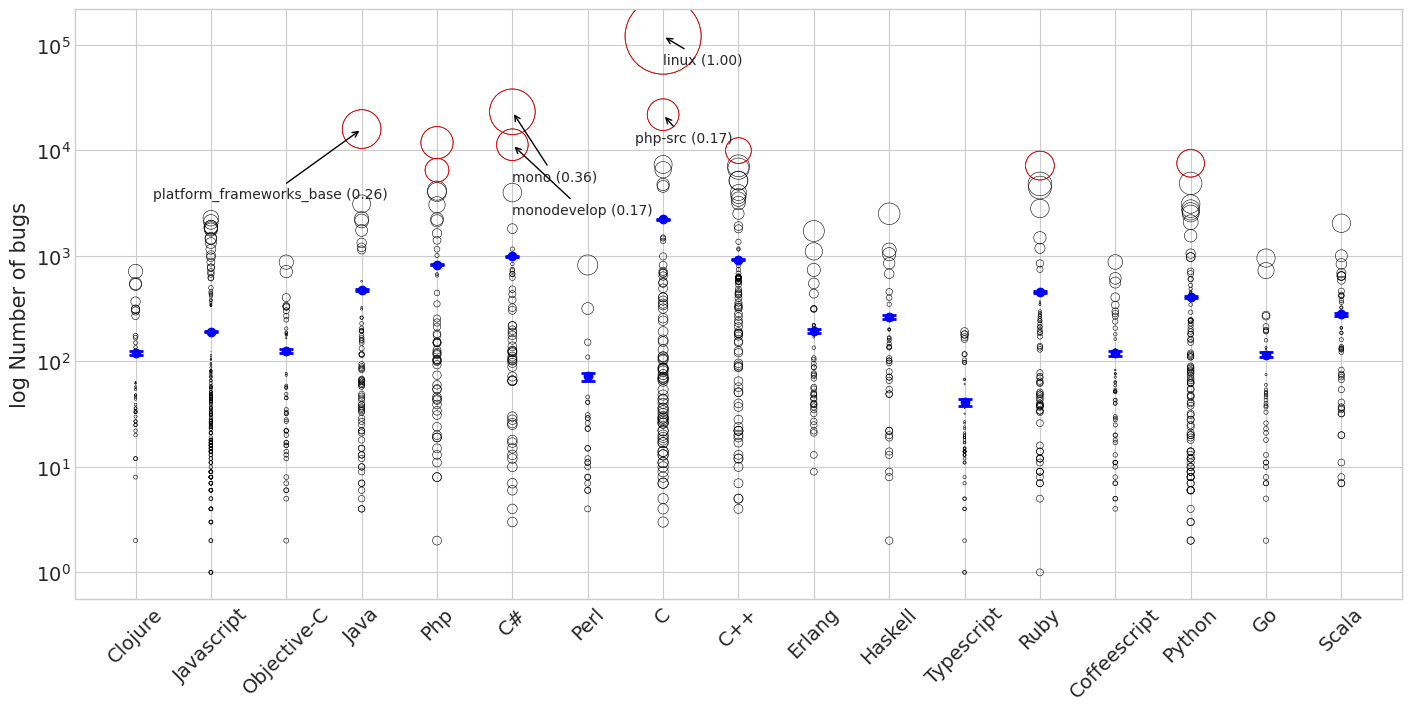

In [144]:
#scale pareto-k values by their max and changing make them nice to plot
pareto_k_h1 /= pareto_k_h1.max()
pareto_k_h1_size = 3000 * pareto_k_h1

#Get the 10 data points with the largest pareto_k_values
top_indices = np.argsort(pareto_k_h1)[-10:][::-1]
top_data_points = df.iloc[top_indices]

#compute error bars of 95 HDI
hdi = az.hdi(post_pred_h1)
lower_bound, upper_bound = hdi.data_vars["lambda"].to_numpy()[:,0], hdi.data_vars["lambda"].to_numpy()[:,1]
diffs = upper_bound - lower_bound  

fig, axes = plt.subplots(figsize=(14,7))
axes.set_yscale("log")


# az.plot_hdi(x_seq, post_pred_h1, color = 'b', fill_kwargs={'alpha': 0.6}, ax=axes)
axes.errorbar(x_seq, post_pred_h1_mean, yerr=center, fmt='o', color='b', ecolor='b', capsize=5, capthick=2)
axes.scatter(df.language, df.bugs, s = pareto_k_h1_size, facecolors='none', edgecolors='k', lw=0.4)
axes.scatter(top_data_points.language, top_data_points.bugs, s = pareto_k_h1_size[top_indices], facecolors='none', edgecolors='r', lw=0.6)
ticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
axes.set_ylabel("log Number of bugs")
axes.set_xticks(ticks=ticks)
axes.set_xticklabels(labels=languages, rotation=45)

#Plotting text for data points with high pareto-k values. We manually adjust the place for the text.
for index, row in top_data_points.iterrows():
    # print(row)
    dont_annotate = False
    if row['language'] == 7 and row['project'] == 'linux':
        position=(0,-20)
    elif row['language'] == 1:
        position=(-70,15)
    elif row['language'] == 5:
        position=(0,-50)
    elif row['language'] == 7 and row['project'] == 'php-src':
        position=(-20,-20)
    elif row["language"] == 3:
        position = (-150,-50)
    else:
        dont_annotate = True
    if dont_annotate == False:
        axes.annotate(f"{row['project']} ({pareto_k_h1[index]:.2f})", xy=(row['language'], row['bugs']), xytext=position,textcoords='offset points', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.show()


The danger for a GLM poisson regression with this dataset is that if a certain language has on average project sizes that are on average multiple orders magnitude greater than other languages, the model might pick up on some false relationships between languages and the number of bugs, simply because the projects written in that language contain more bugs. ( lead to binomial)
* First try only model only with alphas for each language to see if there is an average effect on the number of bugs
* Check if there is any effect from one language over the other simply 

## Conclusion